In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Load dataset

In [2]:
path = "/deeplearning/PJ1/Amazon_Unlocked_Mobile.csv"
df = pd.read_csv(path)

# Preprocessing

In [3]:
df = df[['Reviews', 'Rating']].copy()

df.rename(columns={
    'Reviews': 'review_text',
    'Rating': 'rating'
}, inplace=True)

print(df.head())
print(df.shape)

                                         review_text  rating
0  I feel so LUCKY to have found this used (phone...       5
1  nice phone, nice up grade from my pantach revu...       4
2                                       Very pleased       5
3  It works good but it goes slow sometimes but i...       4
4  Great phone to replace my lost phone. The only...       4
(413840, 2)


In [4]:
# Check for missing values
df.isnull().sum()

review_text    62
rating          0
dtype: int64

In [5]:
# Delete missing values
df.dropna(inplace=True)
print("After drop NA:", df.shape)

After drop NA: (413778, 2)


In [6]:
def label_sentiment(rating):
    if rating <= 2:
        return 0  # negative
    elif rating == 3:
        return 1  # neutral
    else:
        return 2  # positive

df['sentiment'] = df['rating'].apply(label_sentiment)

print(df['sentiment'].value_counts())


2    284954
0     97061
1     31763
Name: sentiment, dtype: int64


In [7]:
import re

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+', '', text)  # remove link
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove symbol
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['clean_text'] = df['review_text'].apply(clean_text)

print(df[['review_text','clean_text']].head())

                                         review_text  \
0  I feel so LUCKY to have found this used (phone...   
1  nice phone, nice up grade from my pantach revu...   
2                                       Very pleased   
3  It works good but it goes slow sometimes but i...   
4  Great phone to replace my lost phone. The only...   

                                          clean_text  
0  i feel so lucky to have found this used phone ...  
1  nice phone nice up grade from my pantach revue...  
2                                       very pleased  
3  it works good but it goes slow sometimes but i...  
4  great phone to replace my lost phone the only ...  


In [8]:
# Add text length feature
df['text_length'] = df['clean_text'].apply(len)
df['word_count'] = df['clean_text'].apply(lambda x: len(x.split()))

In [9]:
# Train-Test split
X = df['clean_text']
y = df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 331022
Test size: 82756


# EDA

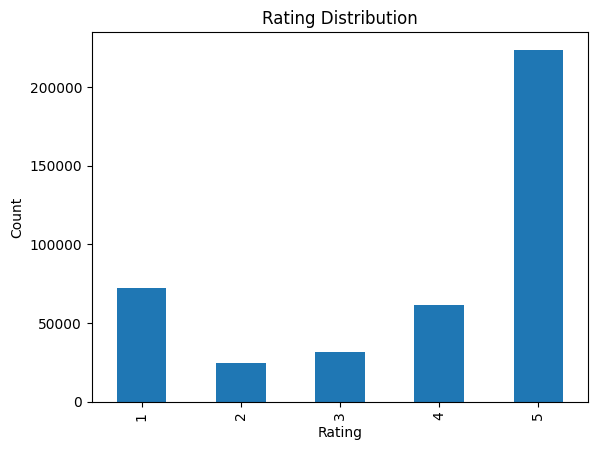

In [10]:
import matplotlib.pyplot as plt

df['rating'].value_counts().sort_index().plot(kind='bar')
plt.title("Rating Distribution")
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

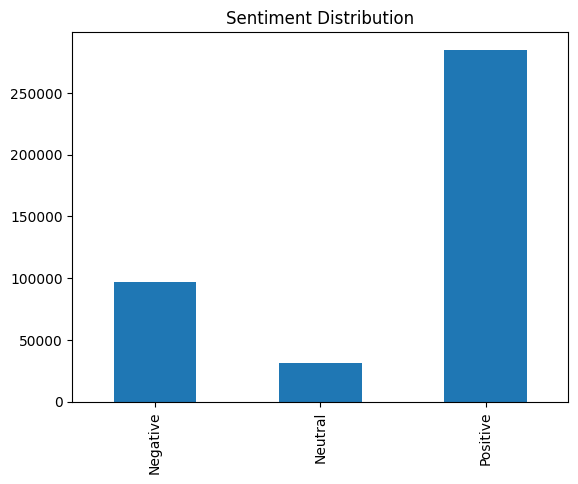

In [11]:
df['sentiment'].value_counts().sort_index().plot(kind='bar')
plt.xticks([0,1,2], ['Negative','Neutral','Positive'])
plt.title("Sentiment Distribution")
plt.show()

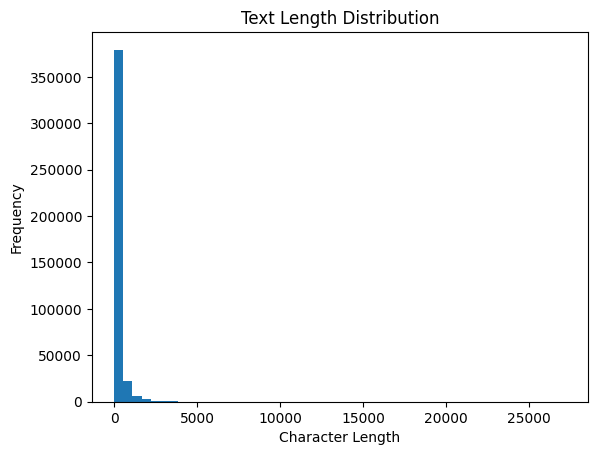

In [12]:
# Text length distribution
plt.hist(df['text_length'], bins=50)
plt.title("Text Length Distribution")
plt.xlabel("Character Length")
plt.ylabel("Frequency")
plt.show()

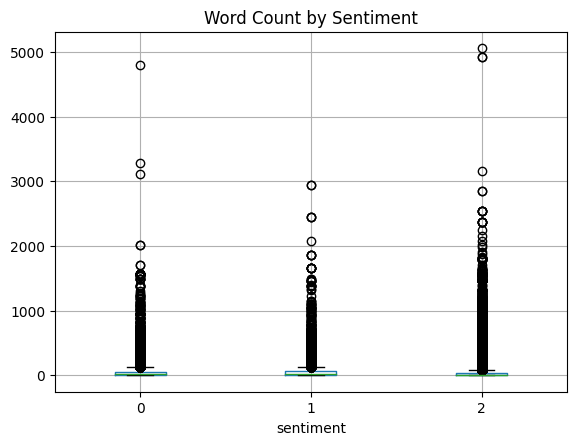

In [13]:
# Comparison of text lengths with different emotions
df.boxplot(column='word_count', by='sentiment')
plt.title("Word Count by Sentiment")
plt.suptitle("")
plt.show()

In [14]:
# High-frequency word analysis
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X_counts = vectorizer.fit_transform(df['clean_text'])

print(vectorizer.get_feature_names())

['battery', 'bought', 'camera', 'dont', 'good', 'great', 'just', 'like', 'love', 'new', 'phone', 'phones', 'price', 'product', 'really', 'screen', 'time', 'use', 'work', 'works']


# Feature Extraction

In [15]:
tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words='english',
    ngram_range=(1,2)  #?
)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Train shape:", X_train_tfidf.shape)
print("Test shape:", X_test_tfidf.shape)

Train shape: (331022, 2000)
Test shape: (82756, 2000)


In [16]:
feature_names = tfidf.get_feature_names()
print(feature_names[:20])

['ability', 'able', 'able use', 'absolutely', 'absolutely love', 'accept', 'acceptable', 'access', 'accessories', 'accidentally', 'according', 'account', 'accurate', 'activate', 'activate phone', 'activated', 'activation', 'active', 'actual', 'actually']


In [17]:
# Check sparsity (understand the data structure)
print("Non-zero elements:", X_train_tfidf.nnz)
print("Sparsity:", 100 * (1 - X_train_tfidf.nnz / (X_train_tfidf.shape[0] * X_train_tfidf.shape[1])))

Non-zero elements: 4769114
Sparsity: 99.27963790926283


# Baseline Model

In [18]:
def evaluate_model(y_true, y_pred, model_name):
    
    acc = accuracy_score(y_true, y_pred)
    print(f"\n===== {model_name} =====")
    print("Accuracy:", acc)
    
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=['Neg','Neu','Pos'],
                yticklabels=['Neg','Neu','Pos'])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    
    return acc

Logistic Regression

Fitting 3 folds for each of 3 candidates, totalling 9 fits


Best Parameters: {'C': 10, 'solver': 'liblinear'}
Best CV Score: 0.6246469581453139

===== Tuned Logistic Regression =====
Accuracy: 0.8594180482381942

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     19412
           1       0.51      0.09      0.15      6353
           2       0.89      0.96      0.92     56991

    accuracy                           0.86     82756
   macro avg       0.73      0.62      0.62     82756
weighted avg       0.84      0.86      0.84     82756



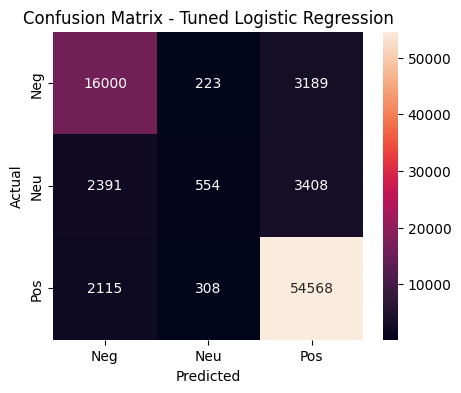

0.8594180482381942

In [19]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    # Small C -> Strong regularization -> Simpler model
    # Large C -> Weak regularization -> More complex model
    'C': [0.1, 1, 10],
    'solver': ['liblinear']
}

# Train in turns
# Calculate f1_macro
# Select the best parameters
grid_lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid,
    cv=3, # Split the training set into 3 parts
    scoring='f1_macro',
    verbose=1
)

grid_lr.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid_lr.best_params_)
print("Best CV Score:", grid_lr.best_score_)

# Model trained with optimal parameters
best_lr = grid_lr.best_estimator_
y_pred_lr_tuned = best_lr.predict(X_test_tfidf)

evaluate_model(y_test, y_pred_lr_tuned, "Tuned Logistic Regression")


===== Logistic Regression =====
Accuracy: 0.8604572478128474

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     19412
           1       0.49      0.11      0.18      6353
           2       0.89      0.96      0.92     56991

    accuracy                           0.86     82756
   macro avg       0.72      0.63      0.64     82756
weighted avg       0.84      0.86      0.84     82756



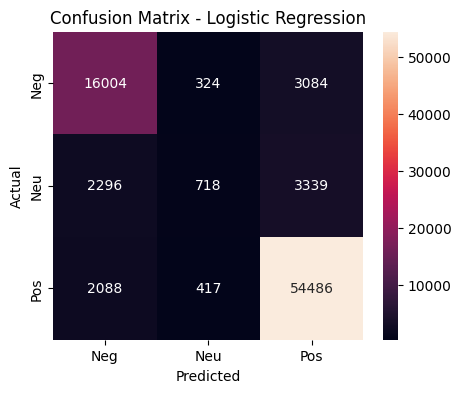

0.8604572478128474

In [20]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)

y_pred_lr_default = lr.predict(X_test_tfidf)

evaluate_model(y_test, y_pred_lr_default, "Logistic Regression")

Error Analysis

In [21]:
# Error Analysis
misclassified = []

for text, true, pred in zip(X_test, y_test, y_pred_lr_tuned):
    if true != pred:
        misclassified.append((text, true, pred))

print("Total misclassified:", len(misclassified))

for i in range(5):
    print("\nText:", misclassified[i][0])
    print("True:", misclassified[i][1], 
          "Predicted:", misclassified[i][2])

Total misclassified: 11634

Text: xperia line has never disappointed me and the z after a few month is my favorite up to date im thinking of getting the xz soon
True: 2 Predicted: 0

Text: i dont want this phone its too small
True: 0 Predicted: 2

Text: i like the phone but i have tried everything to get the glte signal to show up on my phone right now it only shows h went to settings and changed them to lte and still nothing went and had another sim card put in through att and nothing help please
True: 2 Predicted: 0

Text: wouldve been a great phone but had a few dead spots in the touchscreen i dont fancy have to repeatedly touch at a spot to get a response especially when typing
True: 1 Predicted: 2

Text: hi guys i have a problem like that of your solution i bought this phone in your stores and the same was written unlocked but when making use of the phone asks for code
True: 2 Predicted: 0


In [22]:
# Error Analysis
misclassified = []

for text, true, pred in zip(X_test, y_test, y_pred_lr_default):
    if true != pred:
        misclassified.append((text, true, pred))

print("Total misclassified:", len(misclassified))

for i in range(5):
    print("\nText:", misclassified[i][0])
    print("True:", misclassified[i][1], 
          "Predicted:", misclassified[i][2])

Total misclassified: 11548

Text: xperia line has never disappointed me and the z after a few month is my favorite up to date im thinking of getting the xz soon
True: 2 Predicted: 0

Text: i dont want this phone its too small
True: 0 Predicted: 2

Text: i like the phone but i have tried everything to get the glte signal to show up on my phone right now it only shows h went to settings and changed them to lte and still nothing went and had another sim card put in through att and nothing help please
True: 2 Predicted: 0

Text: wouldve been a great phone but had a few dead spots in the touchscreen i dont fancy have to repeatedly touch at a spot to get a response especially when typing
True: 1 Predicted: 2

Text: hi guys i have a problem like that of your solution i bought this phone in your stores and the same was written unlocked but when making use of the phone asks for code
True: 2 Predicted: 0


Naive Bayes



===== Naive Bayes =====
Accuracy: 0.8361568949683407

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.73      0.76     19412
           1       0.34      0.04      0.07      6353
           2       0.86      0.96      0.91     56991

    accuracy                           0.84     82756
   macro avg       0.66      0.58      0.58     82756
weighted avg       0.80      0.84      0.81     82756



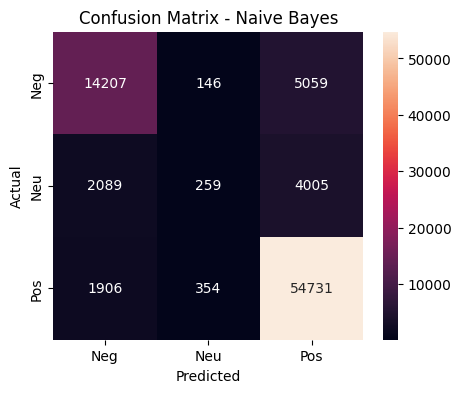

0.8361568949683407

In [23]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

nb_pred = nb_model.predict(X_test_tfidf)

evaluate_model(y_test, nb_pred, "Naive Bayes")

Linear SVM


===== Linear SVM =====
Accuracy: 0.8581734254918072

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.82      0.80     19412
           1       0.57      0.04      0.08      6353
           2       0.89      0.96      0.92     56991

    accuracy                           0.86     82756
   macro avg       0.75      0.61      0.60     82756
weighted avg       0.84      0.86      0.83     82756



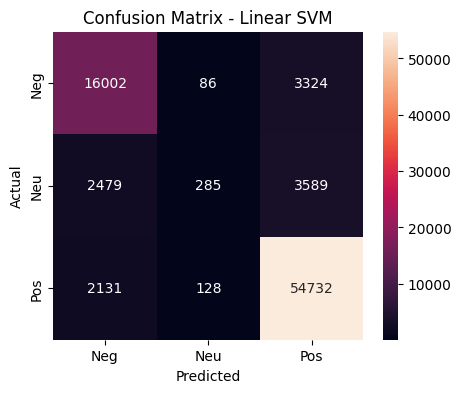

0.8581734254918072

In [24]:
svm = LinearSVC()
svm.fit(X_train_tfidf, y_train)

y_pred_svm = svm.predict(X_test_tfidf)

evaluate_model(y_test, y_pred_svm, "Linear SVM")

# Deep Learning Model(FNN Model)

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

/opt/conda/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"using {device} device")

using cuda device


In [27]:
df_small = df.sample(50000, random_state=42)

X_small = df_small['clean_text']
y_small = df_small['sentiment']

In [28]:
from sklearn.model_selection import train_test_split

X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(
    X_small,
    y_small,
    test_size=0.2,
    random_state=42,
    stratify=y_small
)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=2000,
    stop_words='english'
)

X_train_tfidf_s = tfidf.fit_transform(X_train_s)
X_test_tfidf_s = tfidf.transform(X_test_s)

In [30]:
# Convert to tensor
X_train_tensor = torch.tensor(X_train_tfidf_s.toarray(), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_tfidf_s.toarray(), dtype=torch.float32)

y_train_tensor = torch.tensor(y_train_s.values, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_s.values, dtype=torch.long)

In [31]:
# Build dataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

In [32]:
# Define the FNN model
class FNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [33]:
input_dim = X_train_tensor.shape[1]

In [34]:
def train_and_evaluate(hidden_dim):

    model = FNN(input_dim, hidden_dim, 3)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    epochs = 5   
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

    # Evaluation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    return accuracy


In [35]:
hidden_dims = [64, 128, 256]
results = {}

for h in hidden_dims:
    acc = train_and_evaluate(h)
    results[h] = acc
    print(f"Hidden Dim: {h}, Accuracy: {acc:.4f}")

Hidden Dim: 64, Accuracy: 0.8513
Hidden Dim: 128, Accuracy: 0.8507
Hidden Dim: 256, Accuracy: 0.8513


In [36]:
best_hidden = max(results, key=results.get)
print("\nBest hidden_dim:", best_hidden)
print("Best Accuracy:", results[best_hidden])


Best hidden_dim: 64
Best Accuracy: 0.8513


In [37]:
# Train final model with best hidden size
model = FNN(input_dim, best_hidden, 3)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 20
train_losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)

    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")

Epoch 1, Loss: 0.6237
Epoch 2, Loss: 0.4197
Epoch 3, Loss: 0.3925
Epoch 4, Loss: 0.3755
Epoch 5, Loss: 0.3659
Epoch 6, Loss: 0.3532
Epoch 7, Loss: 0.3452
Epoch 8, Loss: 0.3347
Epoch 9, Loss: 0.3269
Epoch 10, Loss: 0.3196
Epoch 11, Loss: 0.3139
Epoch 12, Loss: 0.3058
Epoch 13, Loss: 0.3007
Epoch 14, Loss: 0.2921
Epoch 15, Loss: 0.2849
Epoch 16, Loss: 0.2769
Epoch 17, Loss: 0.2700
Epoch 18, Loss: 0.2680
Epoch 19, Loss: 0.2585
Epoch 20, Loss: 0.2541


In [38]:
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

accuracy = sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)

print("Final FNN Accuracy:", accuracy)
print(classification_report(all_labels, all_preds))

Final FNN Accuracy: 0.8579
              precision    recall  f1-score   support

           0       0.77      0.81      0.79      2314
           1       0.48      0.22      0.30       767
           2       0.91      0.94      0.92      6919

    accuracy                           0.86     10000
   macro avg       0.72      0.66      0.67     10000
weighted avg       0.84      0.86      0.85     10000



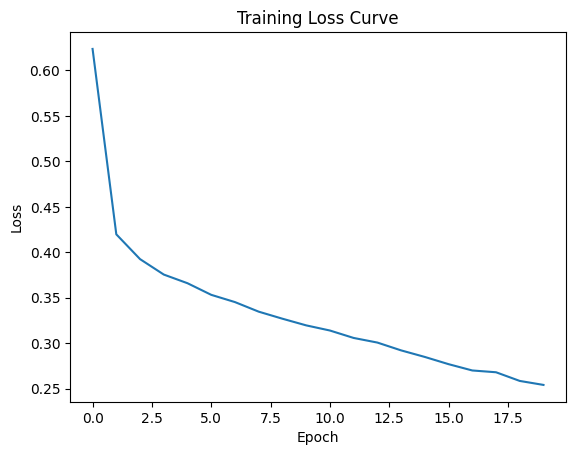

In [39]:
plt.plot(train_losses)
plt.title("Training Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

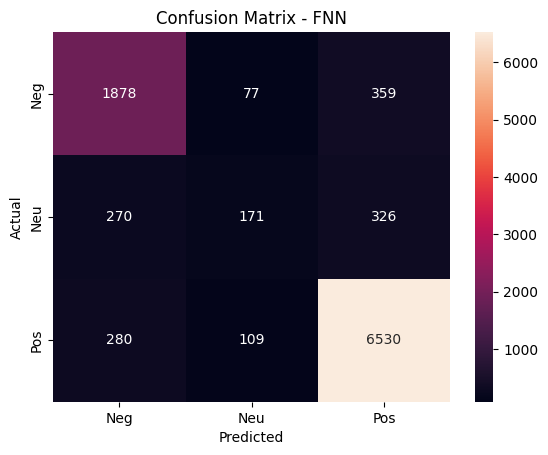

In [40]:
cm = confusion_matrix(all_labels, all_preds)

sns.heatmap(cm,
            annot=True,
            fmt='d',
            xticklabels=['Neg','Neu','Pos'],
            yticklabels=['Neg','Neu','Pos'])

plt.title("Confusion Matrix - FNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

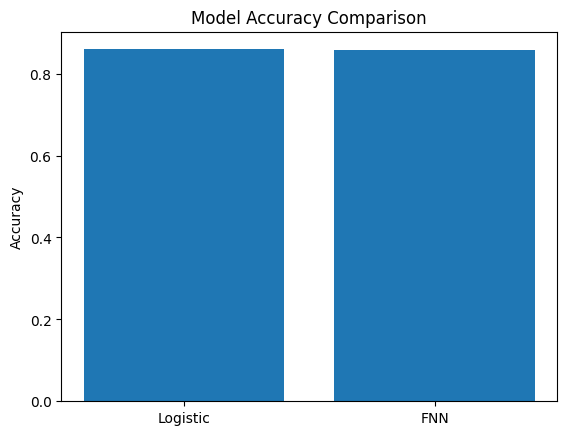

In [41]:
lr_acc = accuracy_score(y_test, y_pred_lr_tuned)
fnn_acc = accuracy

models = ['Logistic', 'FNN']
accuracies = [lr_acc, fnn_acc]

plt.bar(models, accuracies)
plt.title("Model Accuracy Comparison")
plt.ylabel("Accuracy")
plt.show()

Error Analysis

In [42]:
# Error Analysis for FNN
misclassified_fnn = []

for text, true, pred in zip(X_test_s, y_test_s, all_preds):
    if true != pred:
        misclassified_fnn.append((text, true, pred))

print("Total misclassified (FNN):", len(misclassified_fnn))

for i in range(min(5, len(misclassified_fnn))):
    print("\nText:", misclassified_fnn[i][0])
    print("True:", misclassified_fnn[i][1],
          "Predicted:", misclassified_fnn[i][2])

Total misclassified (FNN): 1421

Text: i got this because i pretty much hate all other brands of phones and so far as a nokia its as customizable as i want it to be keep in mind though that as this is an older phone it doesnt have some convenient features of a newer model ie doesnt tell you who a new text is from but these seem negligible to me i really like this phone aside from a couple things sometimes the alarm will just turn itself off not sure why but it seems to help if you leave the clock app up also when the keys are locked there is no way to just hit a button and check the time it just stays dark asks if you want to unlock finally the full keyboard while nice is not quite fast enough to keep up with a normal rate of typing so be prepared to slow down a little bit or keep an eye out for missed letters in you text this is recognized by carriers as a smartphone so be prepared to pay for the required data plan not something i wanted or even new about hope this helps
True: 1 Predi